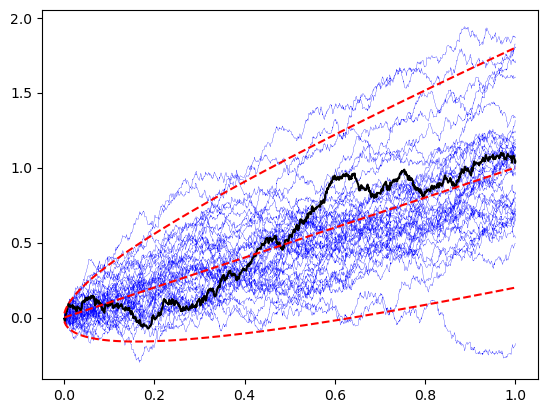

In [20]:
import jax
import jax.random as rnd
from jax import grad, vmap, jit
import jax.numpy as jnp
from jaxtyping import Array
from typing import List
import matplotlib.pyplot as plt


class Distribution():
    def __init__(self, *params):
        self.params = params
    
    def pdf(self, x):
        raise NotImplementedError
    
    def cdf(self, x):
        raise NotImplementedError
    
    def logpdf(self, x):
        raise NotImplementedError
    
    def sample(self, key, *args, **kwargs):
        raise NotImplementedError


class Gridded2D(Distribution):
    def __init__(self, *params):
        super().__init__(*params)
        self.x_lo = params[0]
        self.x_hi = params[1]
        self.y_lo = params[2]
        self.y_hi = params[3]
        self.nx = params[4]
        self.ny = params[5]
        self.count = 0.
        self.grid = jnp.zeros((self.nx, self.ny))
        
    def pdf(self):
        return self.grid/self.count
    
    def cdf(self, x, y):
        raise NotImplementedError
    
    def logpdf(self):
        return jnp.log(self.pdf())
    
    def sample(self, key, shape):
        X,Y = self.get_meshgrid()
        x = X.flatten()
        y = Y.flatten()
        pdf = self.pdf().flatten()
        return rnd.choice(key, x, shape=shape, p=pdf), rnd.choice(key, y, shape=shape, p=pdf)
    
    def update(self, x, y):
        x_idx = jnp.clip(jnp.floor((x-self.x_lo)/(self.x_hi-self.x_lo)*self.nx), 0, self.nx-1).astype(jnp.int32)
        y_idx = jnp.clip(jnp.floor((y-self.y_lo)/(self.y_hi-self.y_lo)*self.ny), 0, self.ny-1).astype(jnp.int32)
        self.grid = self.grid.at[x_idx, y_idx].set(self.grid[x_idx, y_idx]+1)
        self.count += 1
    
    def get_mean(self):
        x = jnp.linspace(self.x_lo, self.x_hi, self.nx)
        y = jnp.linspace(self.y_lo, self.y_hi, self.ny)
        X,Y = jnp.meshgrid(x, y, indexing='ij')
        pdf = self.pdf()
        return jnp.sum(X*pdf), jnp.sum(Y*pdf)
    
    def get_std(self):
        mu_x, mu_y = self.get_mean()
        x = jnp.linspace(self.x_lo, self.x_hi, self.nx)
        y = jnp.linspace(self.y_lo, self.y_hi, self.ny)
        
        X,Y = jnp.meshgrid(x, y, indexing='ij')
        X = X-mu_x
        Y = Y-mu_y
        
        pdf = self.pdf()
        [[jnp.sum(A*B*pdf) for A in [X, Y]] for B in [X, Y]]
        return 
    
    def get_meshgrid(self):
        x = jnp.linspace(self.x_lo, self.x_hi, self.nx)
        y = jnp.linspace(self.y_lo, self.y_hi, self.ny)
        X,Y = jnp.meshgrid(x, y, indexing='ij')
        return X,Y
    
class Normal(Distribution):
    def __init__(self, *params):
        super().__init__(*params)
        self.mu = params[0]
        self.sigma = params[1]
        
    def __mul__(self, other):
        if isinstance(other, float):
            return Normal(self.mu*other, self.sigma*other)
        else:
            raise NotImplementedError
        
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __truediv__(self, other):
        if isinstance(other, float):
            return Normal(self.mu/other, self.sigma/other)
        else:
            raise NotImplementedError
    
    def __add__(self, other):
        if isinstance(other, float):
            return Normal(self.mu + other, self.sigma)
        else:
            raise NotImplementedError
        
    def pdf(self, x):
        mu, sigma = self.params
        return jnp.exp(-0.5*(x-mu)**2/sigma**2) / jnp.sqrt(2*jnp.pi*sigma**2)
    
    def cdf(self, x):
        mu, sigma = self.params
        return 0.5*(1 + jax.scipy.special.erf((x-mu)/(sigma*jnp.sqrt(2))))
    
    def logpdf(self, x):
        mu, sigma = self.params
        return -0.5*(x-mu)**2/sigma**2 - jnp.log(jnp.sqrt(2*jnp.pi*sigma**2))
    
    def sample(self, key, shape):
        mu, sigma = self.params
        return mu + sigma * rnd.normal(key, shape)
    
    def conjugate_update(self, obs_other: List[float], other: List[Distribution]):
        assert all(isinstance(o, Normal) for o in other), "All distributions must be Normal"
        sigma = (1/self.sigma**2 + sum([1/o.sigma**2 for o in other]))**(-0.5)
        mu = (self.mu/self.sigma**2 + sum([x/o.sigma**2 for (o,x) in zip(other, obs_other)]))*sigma**2
        return Normal(mu, sigma)

    def get_mean(self):
        return self.mu
    
    def get_std(self):
        return self.sigma
    
class InverseGamma(Distribution):
    def __init__(self, *params):
        super().__init__(*params)
        self.alpha = params[0]
        self.beta = params[1]
    
    def pdf(self, x):
        alpha, beta = self.params
        return beta**alpha / jax.scipy.special.gamma(alpha) * x**(-alpha-1) * jnp.exp(-beta/x)
    
    def cdf(self, x):
        alpha, beta = self.params
        return jax.scipy.special.gammainc(alpha, beta/x)
    
    def logpdf(self, x):
        alpha, beta = self.params
        return alpha*jnp.log(beta) - jax.scipy.special.gammaln(alpha) - (alpha+1)*jnp.log(x) - beta/x
    
    def sample(self, key, shape):
        alpha, beta = self.params
        return (1. / rnd.gamma(key, alpha, shape) * beta)**0.5
    
    def conjugate_update(self, obs_other: Array, other: List[Distribution]):
        assert all(isinstance(o, Normal) for o in other), "All distributions must be InverseGamma"
        alpha = self.alpha + 0.5*len(other)
        beta = self.beta + 0.5*sum([(x - o.mu)**2 for (o,x) in zip(other, obs_other)])
        return InverseGamma(alpha, beta)
    
    def get_mean(self):
        return self.beta / (self.alpha - 1)
    
    def get_std(self):
        return self.beta / ((self.alpha - 1) * (self.alpha - 2)**0.5)
    
class LinearSDE(Distribution):
    def __init__(self, *params):
        super().__init__(*params)
        self.x0 = params[0]
        self.mu = params[1]
        self.sigma = params[2]
        
    def pdf(self, x, t):
        return jnp.exp(self.logpdf(x, t))
        
    
    def cdf(self, x):
        raise NotImplementedError
    
    def logpdf(self, x, t):
        return self.logpdf_static(x, t, self.mu, self.sigma, self.x0)
    
    def sample(self, key, t, n):
        dt = jnp.concatenate([jnp.array([t[0]-0]), t[1:] - t[:-1]])
        dw = rnd.normal(key, (n,)) * (dt)**0.5
        x = self.x0 + self.mu*t + self.sigma*jnp.cumsum(dw)
        return x
    
    def plot(self, t, x=None, **kwargs):
        sqrt_t = jnp.sqrt(t)
        if x is not None:
            plt.plot(t, x, 'k')
        plt.plot(t, self.x0 + self.mu*t, label="trend", **kwargs)
        plt.plot(t, self.x0 + self.mu*t + 2*self.sigma*sqrt_t, label="trend+sigma", **kwargs)
        plt.plot(t, self.x0 + self.mu*t - 2*self.sigma*sqrt_t, label="trend-sigma", **kwargs)
    
    @staticmethod
    def logpdf_static(x, t, mu, sigma, x0):
        dt = jnp.concatenate([jnp.array([t[0]-0]), t[1:] - t[:-1]])
        dx = jnp.concatenate([jnp.array([x[0]-x0]), x[1:] - x[:-1]])
        return jnp.sum(-0.5*(dx-mu*dt)**2/(sigma**2*dt) - jnp.log(jnp.sqrt(2*jnp.pi*sigma**2*dt)))
    
    
    @staticmethod
    def pdf_static(x, t, mu, sigma, x0):
        return jnp.exp(LinearSDE.logpdf_static(x, t, mu, sigma, x0))

def sample_mu_sigma(key, t: Array, x: Array, x0: float, mu_prior: Normal, sigma_prior: InverseGamma, grid: Gridded2D):
    # Gibbs sampling
    dx = jnp.concatenate([jnp.array([x[0]-x0]), x[1:] - x[:-1]])
    dt = jnp.concatenate([jnp.array([t[0]-0]), t[1:] - t[:-1]])
    mu = mu_prior.sample(key, ())
    key, _ = rnd.split(key)
    for i in range(500):
        key, key1, key2 = rnd.split(key, 3)
        
        # update sigma prior
        sigma_post = sigma_prior.conjugate_update((dx - mu*dt)/jnp.sqrt(dt), [Normal(0., 1.)]*len(dx))
        sigma = sigma_post.sample(key1, ())
        
        # update mu prior
        mu_post = mu_prior.conjugate_update(dx/dt, [Normal(mu, sigma/dti**0.5) for dti in dt])
        mu = mu_post.sample(key2, ())
        grid.update(mu, sigma)
        print(f"iter:{i}, mu={mu}, sigma={sigma}", end='\r')
    
    return mu, sigma
        
        
def sample_mu_sigma_fast(key, Nsamples, t: Array, x: Array, x0: float, mu_param: Array, sigma_param: Array, grid: Gridded2D):
    # Gibbs sampling
    n = len(t)
    dx = jnp.concatenate([jnp.array([x[0]-x0]), x[1:] - x[:-1]])
    dt = jnp.concatenate([jnp.array([t[0]-0]), t[1:] - t[:-1]])
    
    sigma_alpha_prior, sigma_beta_prior = sigma_param
    mu_mean_prior, mu_std_prior = mu_param
    
    mu = rnd.normal(key, ()) * mu_std_prior + mu_mean_prior
    key, _ = rnd.split(key)
    
    # For sigma update
    dxdx_invdt_sum = jnp.sum(dx*dx/dt)
    dx_sum = jnp.sum(dx)
    dt_sum = jnp.sum(dt)
    
    for i in range(Nsamples):
        key, key1, key2 = rnd.split(key, 3)
        
        # update sigma prior
        # (dx-mu*dt)/sqrt(dt) ~ N(0, sigma)
        # sum((dx-mu*dt)^2/dt) = sum(dxdx/dt - 2*mu*dxdt/dt +  mu^2*dtdt/dt)
        sigma_alpha_post = sigma_alpha_prior + 0.5*n
        sigma_beta_post = sigma_beta_prior + 0.5*(dxdx_invdt_sum - 2*mu*dx_sum + mu**2*dt_sum)
        sigma = (1. / rnd.gamma(key1, sigma_alpha_post, ()) * sigma_beta_post)**0.5
        
        # update mu prior
        # dx/dt = N(mu, sigma/sqrt(dt))
        # sum(1/(sigma/sqrt(dt))^2) = sum(dt/sigma^2)
        # sum((dx/dt)/(sigma/sqrt(dt))^2) = sum(dx/sigma^2)
        mu_std_post = (1./mu_std_prior**2 + dt_sum/sigma**2)**(-0.5)
        mu_mean_post = (mu_mean_prior/mu_std_prior**2 + dx_sum/sigma**2) * mu_std_post**2
        mu = rnd.normal(key2, ()) * mu_std_post + mu_mean_post
        grid.update(mu, sigma)
        
        print(f"iter:{i}, mu={mu}, sigma={sigma}", end='\r')
    
    return mu, sigma
        

def mle(x, t, x0):#, mu0, sigma0):
    dx = jnp.concatenate([jnp.array([x[0]-x0]), x[1:] - x[:-1]])
    dt = jnp.concatenate([jnp.array([t[0]-0.]), t[1:] - t[:-1]])
    
    mu = jnp.mean(dx/dt)
    sigma = jnp.sqrt(jnp.mean((dx-mu*dt)**2/dt))
    return mu, sigma
      
sigma_prior = InverseGamma(1., 1.)
mu_prior = Normal(0., 30.)

x0 = 0.
mu = 1.
sigma = 0.4
n = 1200
Nsamples = 4000

grid_extent = [mu-4*sigma, mu+4*sigma, 0.7*sigma, 1.3*sigma]
grid = Gridded2D(*grid_extent, 60, 80)

key = rnd.PRNGKey(0)
key, key1, key2, key3 = rnd.split(key, 4)

t = jnp.sort(rnd.uniform(key1, (n,)))+jnp.linspace(0.1, 1, n)*0.0001
X = LinearSDE(x0, mu, sigma)
x = X.sample(key2, t, n)

for i in range(40):
    key, key1 = rnd.split(key, 2)
    plt.plot(t, X.sample(key1, t, n), linestyle='-', linewidth=0.2, color='blue')
X.plot(t, x, linestyle='--', color='red')


In [21]:
# Gibbs sampling
#mu0, sigma0 = sample_mu_sigma(rnd.PRNGKey(1), t, x, x0, mu_prior, sigma_prior, grid)
_, _ = sample_mu_sigma_fast(key3, Nsamples, t, x, x0, mu_prior.params, sigma_prior.params, grid)

In [22]:

mu_mle, sigma_mle = mle(x, t, x0)

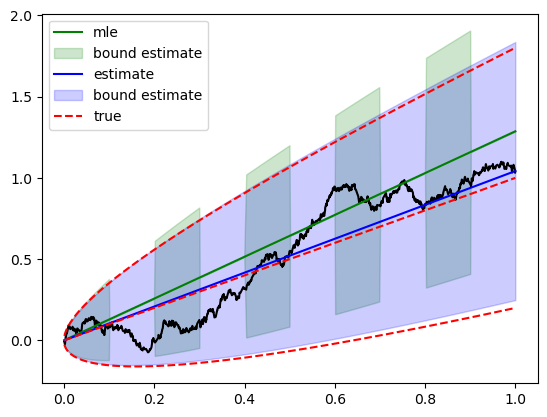

In [23]:
mu_mean, sigma_mean = grid.get_mean()

plt.figure()
plt.plot(t, x, 'k')

# Estimate
k = 2
plt.plot(t, x0 + mu_mle*t, color="green", label="mle")
mask = t % 0.2 < 0.1
plt.fill_between(t, x0 + mu_mle*t - k*sigma_mle*t**0.5*mask, x0 + mu_mle*t + k*sigma_mle*t**0.5*mask, alpha=0.2, color="green", label="bound estimate")

plt.plot(t, x0 + mu_mean*t, color="blue", label="estimate")
plt.fill_between(t, x0 + mu_mean*t - k*sigma_mean*t**0.5, x0 + mu_mean*t + k*sigma_mean*t**0.5, alpha=0.2, color="blue", label="bound estimate")


# True signal
plt.plot(t, x0 + mu*t, color="red", linestyle="--")
plt.plot(t, x0 + mu*t - k*sigma*t**0.5, color="red", linestyle="--")
plt.plot(t, x0 + mu*t + k*sigma*t**0.5, color="red", linestyle="--", label="true")
plt.legend()


<Figure size 500x500 with 0 Axes>

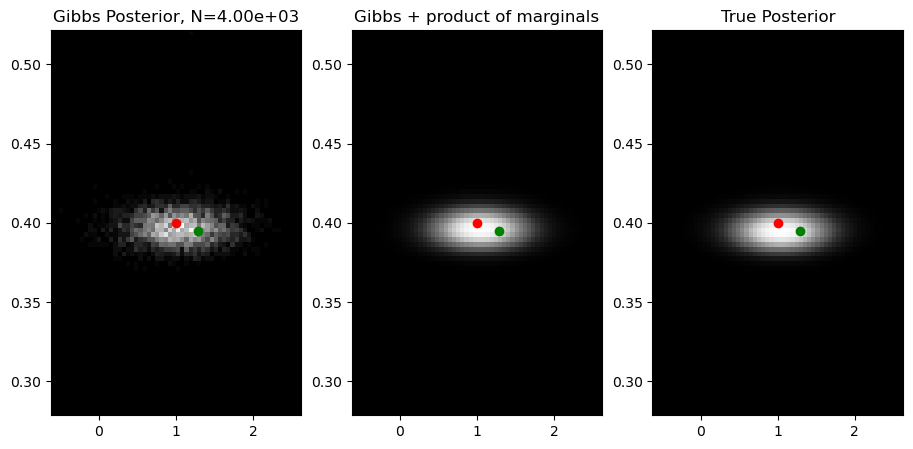

In [24]:
plt.figure(figsize=(5, 5))
M, S = grid.get_meshgrid()

# Gibbs
pdf = grid.pdf()

# Tensor
dx = jnp.concatenate([jnp.array([x[0]-x0]), x[1:] - x[:-1]])
dt = jnp.concatenate([jnp.array([t[0]-0]), t[1:] - t[:-1]])
ScX = sigma_prior.conjugate_update((dx - mu_mean*dt)/jnp.sqrt(dt), [Normal(0., 1.)]*len(dx))
McX = mu_prior.conjugate_update(dx/dt, [Normal(mu_mean, sigma_mean/dti**0.5) for dti in dt])
logpdf_tensor = lambda mu, std: ScX.logpdf(std**2) + McX.logpdf(mu)
logpdf_tensor = vmap(vmap(logpdf_tensor, (0, 0)), (0, 0))(M, S)
pdf_tensor = jnp.exp(logpdf_tensor - jnp.max(logpdf_tensor))

# True
logpdf_true = lambda mu, std: X.logpdf_static(x, t, mu, std, x0) + mu_prior.logpdf(mu) + sigma_prior.logpdf(std)
logpdf_true = vmap(vmap(logpdf_true, (0, 0)), (0, 0))(M, S)
pdf_true = jnp.exp(logpdf_true - jnp.max(logpdf_true))

plt.figure(figsize=(11, 5))
cmap = "Greys_r"

plt.subplot(131)
plt.title(f"Gibbs Posterior, N={Nsamples:.2e}")
plt.pcolormesh(M, S, grid.pdf(), cmap=cmap)
plt.scatter(mu, sigma, color='red')
plt.scatter(mu_mle, sigma_mle, color='green')

plt.subplot(132)
plt.title("Gibbs + product of marginals")
plt.pcolormesh(M, S, pdf_tensor, cmap=cmap)
plt.scatter(mu, sigma, color='red')
plt.scatter(mu_mle, sigma_mle, color='green')

plt.subplot(133)
plt.title("True Posterior")
plt.pcolormesh(M, S, pdf_true, cmap=cmap)
plt.scatter(mu, sigma, color='red')
plt.scatter(mu_mle, sigma_mle, color='green')


In [25]:

key, key1, key2 = rnd.split(key, 3)
T = 0.5
N = 100000
mus, sigmas = grid.sample(key1, (N,))
y_list = x[-1] + mus*T + sigmas*jnp.sqrt(T)*rnd.normal(key2, (N,))
y_mean = jnp.mean(y_list)
y_std = jnp.std(y_list)


y_range = jnp.linspace(y_list.min(), y_list.max(), 100)
t_predict = jnp.linspace(t[-1], t[-1]+T, 20)

(-0.0710404189079096, 1.4918502298217402, -0.1, 2.5)

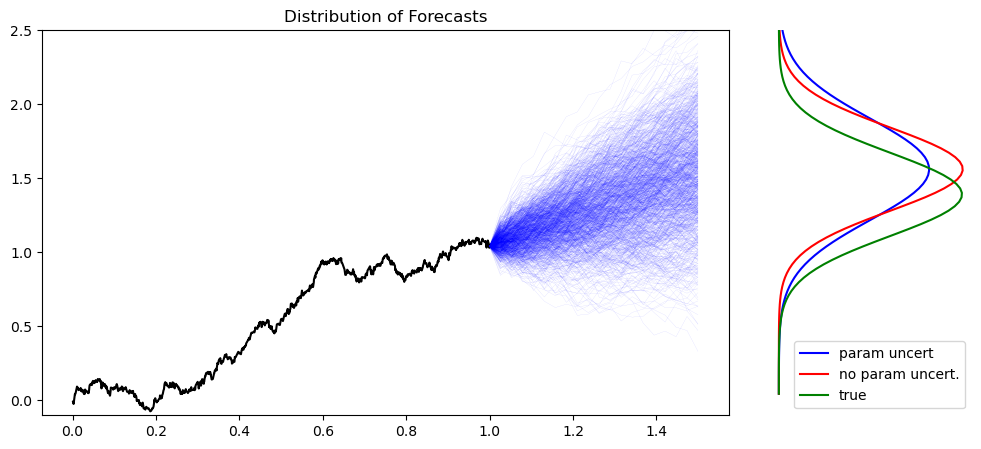

In [26]:

plt.figure(figsize=(12,5))
ylim = [-0.1, 2.5]
ax = plt.subplot2grid((1,4), (0,0), rowspan=1,colspan=3)
plt.title("Distribution of Forecasts")
ax.plot(t, x, 'k')
for i in range(1000):
    key, key1, key2 = rnd.split(key, 3)
    mu, sigma = grid.sample(key1, ())
    y = LinearSDE(x[-1], mu, sigma).sample(key1, t_predict-t_predict[0], len(t_predict))
    ax.plot(t_predict, y, linestyle='-', alpha=0.3, linewidth=0.1, color='blue')
    
    #y2 = LinearSDE(x[-1], mu_mean, sigma_mean).sample(key2, t_predict-t_predict[0], len(t_predict))
    #ax.plot(t_predict, y2, linestyle='-', alpha=0.2, linewidth=0.1, color='red')
ax.set_ylim(*ylim)  
    
# vertical histogram:
ax = plt.subplot2grid((1,4), (0,3), rowspan=1,colspan=1)
#ax.hist(y_list, bins=80, orientation='horizontal', alpha=0.5, color='blue', density=True)
ax.plot(jnp.exp(-(y_range-y_mean)**2/(2*y_std**2))/jnp.sqrt(2*jnp.pi*y_std**2), y_range, color='blue', label="param uncert")
ax.plot(jnp.exp(-(y_range-x[-1]-mu_mean*T)**2/(2*sigma_mean**2*T))/jnp.sqrt(2*jnp.pi*sigma_mean**2*T), y_range, color='red', label="no param uncert.")
ax.plot(jnp.exp(-(y_range-x[-1]-mu*T)**2/(2*sigma**2*T))/jnp.sqrt(2*jnp.pi*sigma**2*T), y_range, color='green', label="true")
plt.legend()
ax.set_ylim(*ylim)  
ax.axis("off")
